In [1]:
# Choose the layer to test
#
#LAYER = 'depthwise_conv2d' # 
#LAYER = 'pointwise_conv2d'
LAYER = 'separable_conv2d' # uses both depthwise and pointwise
#LAYER = 'depthwise_conv2d'
RUN_HLS = True
IO_TYPE = 'io_parallel'
STRATEGY = 'Latency'
BACKEND = 'Vivado'

H = 23  # Input height
W = 23   # Input width
FXD_W = 8 # Fixed-point precision, word bit width
FXD_I = 3 # Fixed-point precision, integer-part bit width
reuseFactor = 1
parallelFactor = 1


Din = 2  # Input # of channels     --------------> Not moving
Fh = 3   # Kernel height    -------------> Not moving
Fw = 3  # Kernel width  -------------- > Not moving
Dout = 5 # Kernel # of filters --------------> Not moving

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten

from tensorflow.keras.models import Sequential

from qkeras import *

2024-07-22 19:05:13.149241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os

In [4]:
#os.environ['PATH'] = '/home/xilinx/Vivado/2019.1/bin:' + os.environ['PATH'] 

In [5]:
os.environ['PATH'] = '/data/software/xilinx/Vivado/2020.1/bin:' + os.environ['PATH'] #Mulder

In [6]:
LAYER

'separable_conv2d'

In [7]:
!ls /data/software/xilinx/Vitis/

2020.1	2023.2


kmodel...

In [8]:
def CreateKerasModel(layer, input_shape, kernel_size, filters):
 
    x_in = Input(input_shape, name='input_1')
    if layer == 'depthwise_conv2d':
        x = DepthwiseConv2D(
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            bias_initializer=tf.keras.initializers.Zeros(), # makes debugging easy
            name='depthwise_conv2d'
        )(x_in)
    elif layer == 'pointwise_conv2d':
        x_out = Conv2D(
            filters=filters,
            kernel_size=(1,1),
            use_bias=False,
            kernel_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            bias_initializer=tf.keras.initializers.Zeros(), # makes debugging easy
            name='pointwise_conv2d'
        )(x_in)
    else:
        x= SeparableConv2D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            pointwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            name = 'separable_conv2d'
    )(x_in)
    x = Flatten()(x)
    x_out = Dense(2)(x)
    kmodel = Model(inputs=x_in, outputs=x_out)
    return kmodel

In [9]:
kmodel = CreateKerasModel(LAYER, input_shape=(H,W,Din), kernel_size=(Fh, Fw), filters=Dout)
kmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23, 23, 2)]       0         
                                                                 
 separable_conv2d (Separable  (None, 21, 21, 5)        28        
 Conv2D)                                                         
                                                                 
 flatten (Flatten)           (None, 2205)              0         
                                                                 
 dense (Dense)               (None, 2)                 4412      
                                                                 
Total params: 4,440
Trainable params: 4,440
Non-trainable params: 0
_________________________________________________________________


2024-07-22 19:05:22.989475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
import numpy as np

In [11]:
X_train = np.random.rand(10,H,W,Din)  
y_train = np.random.randint(2, size=(10,))

In [12]:
y_train

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1])

In [13]:
#X = np.random.rand(1000, 10)  # 1000 samples with 10 features
#Y = np.random.randint(2, size=(1000,))  # Binary labels (0 or 1)


In [14]:
import tensorflow

In [15]:
kmodel.compile(loss="binary_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(
    learning_rate=0.001), metrics=["binary_accuracy"])


In [16]:
kmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23, 23, 2)]       0         
                                                                 
 separable_conv2d (Separable  (None, 21, 21, 5)        28        
 Conv2D)                                                         
                                                                 
 flatten (Flatten)           (None, 2205)              0         
                                                                 
 dense (Dense)               (None, 2)                 4412      
                                                                 
Total params: 4,440
Trainable params: 4,440
Non-trainable params: 0
_________________________________________________________________


In [17]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=100)

In [18]:
history=kmodel.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=50,
    verbose=2,
    #sample_weight=np.asarray(weights),
    validation_split=0.20,
    callbacks=[callback],
)

Epoch 1/50
1/1 - 1s - loss: 7.6576 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000 - 564ms/epoch - 564ms/step
Epoch 2/50
1/1 - 0s - loss: 7.6576 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000 - 27ms/epoch - 27ms/step
Epoch 3/50
1/1 - 0s - loss: 7.6576 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000 - 26ms/epoch - 26ms/step
Epoch 4/50
1/1 - 0s - loss: 7.6576 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000 - 26ms/epoch - 26ms/step
Epoch 5/50
1/1 - 0s - loss: 7.6576 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000 - 26ms/epoch - 26ms/step
Epoch 6/50
1/1 - 0s - loss: 7.6576 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000 - 26ms/epoch - 26ms/step
Epoch 7/50
1/1 - 0s - loss: 7.6576 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000 - 26ms/epoch - 26ms/step
Epoch 8/50
1/1 - 0s - loss: 7.6576 - binary_accuracy:

In [19]:
import hls4ml.utils
import hls4ml.converters

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/users/russelld/VladBranch_SepConv2D/work/SepConv2D_hls4ml/Software/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [20]:
import hls4ml.model.profiling

In [21]:
config = hls4ml.utils.config_from_keras_model(kmodel, granularity='name')
print("-----------------------------------")

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 23, 23, 2]], output shape: [None, 23, 23, 2]
Layer name: separable_conv2d, layer type: SeparableConv2D, input shapes: [[None, 23, 23, 2]], output shape: [None, 21, 21, 5]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 21, 21, 5]], output shape: [None, 2205]
Layer name: dense, layer type: Dense, input shapes: [[None, 2205]], output shape: [None, 2]
-----------------------------------


In [22]:
#config['LayerName']['q_input_1']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
config['LayerName']['input_1']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
config['Model']['Strategy'] = STRATEGY
#config['Model']['Strategy'] = 'Resource'
config['LayerName']['separable_conv2d']['ReuseFactor'] = reuseFactor
config['LayerName']['separable_conv2d']['ParallelizationFactor'] = parallelFactor

In [30]:
#(FXD_W, FXD_I)

In [23]:
for layer in config['LayerName'].keys():
    print('Enable tracing for layer:', layer)
    config['LayerName'][layer]['Trace'] = True

Enable tracing for layer: input_1
Enable tracing for layer: separable_conv2d
Enable tracing for layer: separable_conv2d_linear
Enable tracing for layer: flatten
Enable tracing for layer: dense
Enable tracing for layer: dense_linear


In [23]:
!pwd

/home/users/russelld/VladBranch_SepConv2D/work/SepConv2D_hls4ml


In [24]:
hls_kmodel = hls4ml.converters.convert_from_keras_model(
    kmodel, 
    hls_config=config, 
    output_dir=f'/home/users/russelld/VladBranch_SepConv2D/work/SepConv2D_hls4ml/HLS4ML_PROJ_sepConv2D/proj_{FXD_W}-{FXD_I}_rf_{reuseFactor}_pf_{parallelFactor}_InH{H}_InW{W}/qkmodel', 
    part='xcu250-figd2104-2L-e',
    backend=BACKEND,
    io_type=IO_TYPE
)

hls_kmodel.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 23, 23, 2]], output shape: [None, 23, 23, 2]
Layer name: separable_conv2d, layer type: SeparableConv2D, input shapes: [[None, 23, 23, 2]], output shape: [None, 21, 21, 5]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 21, 21, 5]], output shape: [None, 2205]
Layer name: dense, layer type: Dense, input shapes: [[None, 2205]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done


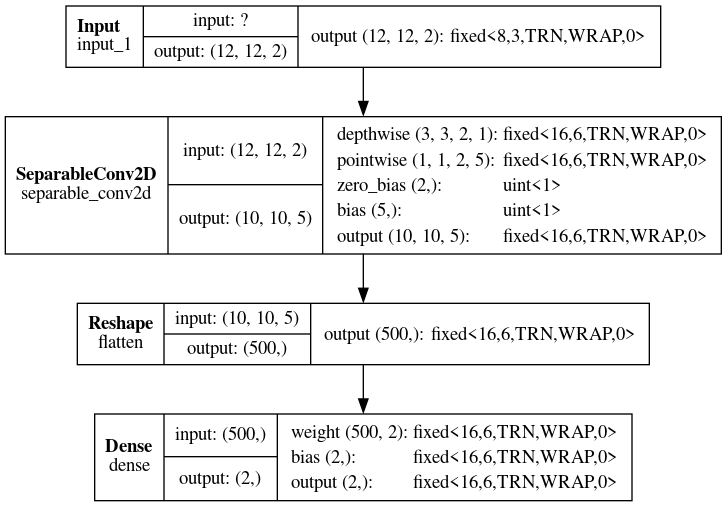

In [32]:
hls4ml.utils.plot_model(hls_kmodel, show_shapes=True, show_precision=True, to_file=None)

In [26]:
y_hls, hls4ml_trace = hls_kmodel.trace(X_train)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(kmodel, X_train)

Recompiling myproject with tracing
Writing HLS project
Done
1/1 [==============================] - 0s 68ms/step
Done taking outputs for Keras model.


In [27]:
hls4ml_trace[LAYER].flatten().shape

(5000,)

In [28]:
#LAYER='depthwise_conv2d'
#LAYER= 'separable_conv2d'

In [29]:
keras_trace[LAYER].flatten().shape

(5000,)

In [30]:
import matplotlib.pyplot as plt
import numpy as np

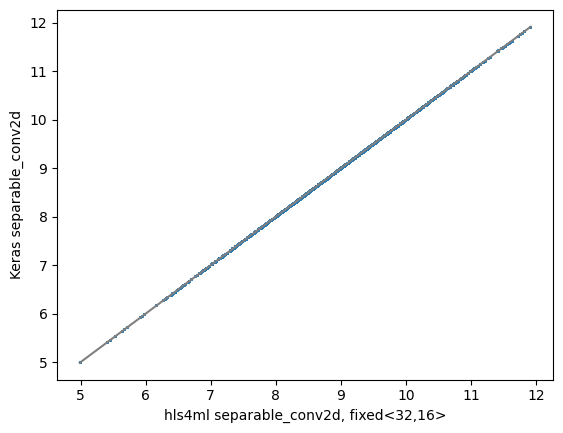

In [31]:
plt.scatter(hls4ml_trace[LAYER].flatten(), keras_trace[LAYER].flatten(), s=0.8)
min_x = min(np.amin(hls4ml_trace[LAYER]), np.amin(keras_trace[LAYER]))
max_x = max(np.amax(hls4ml_trace[LAYER]), np.amax(keras_trace[LAYER]))
plt.plot([min_x, max_x], [min_x, max_x], c='gray')
plt.xlabel('hls4ml {}, fixed<{},{}>'.format(LAYER,FXD_W, FXD_I))
#plt.xlabel('hls4ml {}'.format(LAYER))
plt.ylabel('Keras {}'.format(LAYER))
#plt.savefig(f"LayerTraces/Traces_Precision_{FXD_W}-{FXD_I}_rf_{reuseFactor}_pf_{parallelFactor}_InH{H}_InW{W}.png")
plt.savefig(f"/home/users/russelld/VladBranch_SepConv2D/work/SepConv2D_hls4ml/HLS4ML_PROJ_sepConv2D/proj_{FXD_W}-{FXD_I}_rf_{reuseFactor}_pf_{parallelFactor}_InH{H}_InW{W}/traces.png")

NameError: name 'report' is not defined

In [25]:
report = hls_kmodel.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/software/xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/software/xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'russelld' on host 'mulder.t2.ucsd.edu' (Linux_x86_64 version 4.18.0-425.3.1.el8.x86_64) on Mon Jul 22 19:08:27 PDT 2024
INFO: [HLS 200-10] On os "AlmaLinux release 8.10 (Cerulean Leopard)"
INFO: [HLS 200-10] In directory '/home/users/russelld/VladBranch_SepConv2D/work/SepConv2D_hls4ml/HLS4ML_PROJ_sepConv2D/proj_8-3_rf_1_pf_1_InH23_InW23/qkmodel'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/users/russelld/VladBranch_SepConv2D/work/S

In [26]:
report

{}

In [37]:
i = 2
print("i = ", i)
for i in range(2,3):
    print("hello", i)

i =  2
hello 2


In [1]:
try: 
    a = 2
except KeyError:
    print("Failed.")

In [2]:
a

2

In [46]:
k =1
for i in range(1,1+k):    
    try:
        hls_m = report['CSynthesisReport']
    except KeyError:
        KEY = "FAILED"
    if KEY == "FAILED":
        print(i)
        k += 1
    elif i == 5: 
        break

1


In [51]:
j = 2
W = 2
while j == W:   
    j = W
    if j < 5:
        j += 1
        W += 1
        print(j, W)
    else: break
    

3 3
4 4
5 5


In [52]:
k = 2
m = 2

In [55]:
i = k
j = m
n = 0
l = [True, True, True, False]
while True:
    while True:
        if m == k:
            print("they are equal")
            n += 1
            break  
        else: 
            m += 1
    if n == 2:
        break
    


they are equal
they are equal


In [30]:
id(report)

140335976948672

In [33]:
#hls4ml.report.read_vivado_report("/home/users/russelld/sConv2D_hls4ml/SepConv2D_hls4ml/small_kmod_hls4ml_prj")
hls4ml.report.read_vivado_report(f'/home/users/russelld/VladBranch_SepConv2D/work/SepConv2D_hls4ml/HLS4ML_PROJ_sepConv2D/proj_{FXD_W}-{FXD_I}_rf_{reuseFactor}_pf_{parallelFactor}_InH{H}_InW{W}/qkmodel')

Found 1 solution(s) in /home/users/russelld/VladBranch_SepConv2D/work/SepConv2D_hls4ml/HLS4ML_PROJ_sepConv2D/proj_32-16_rf_1_pf_4_InH12_InW12/qkmodel/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Thu Jul  4 16:46:34 2024

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.235 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline 

In [31]:
a=5

In [33]:
id(a)

140353684013424

In [34]:
if True
    b = D 

SyntaxError: expected ':' (3707121663.py, line 1)

### -------- Only focusing on the above for now. I will try QKeras afterwards.

QKeras model...

In [ ]:
def CreateQKerasModel(type, input_shape, kernel_size, filters):
    # # Generate the same random values
    # import random
    # import numpy as np
    # import tensorflow as tf

    # random.seed(42)
    # np.random.seed(42)
    # tf.random.set_seed(42)
    
    x_in = Input(input_shape, name='q_input_1')
    if type == 'depthwise_conv2d':
        x_out = QDepthwiseConv2D(
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            depthwise_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            bias_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            name='q_depthwise_conv2d'
        )(x_in)
    elif type == 'pointwise_conv2d':
        x_out = QConv2D(
            kernel_size=(1,1), # 1x1 convolution
            filters=filters,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            kernel_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            bias_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            name='q_pointwise_conv2d'
        )(x_in)
    else:
        x_out = QSeparableConv2D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            pointwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            depthwise_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            pointwise_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            bias_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            name='q_separable_conv2d'
        )(x_in)
    
    qkmodel = Model(inputs=x_in, outputs=x_out)
    return qkmodel

In [ ]:
qkmodel = CreateQKerasModel(LAYER, input_shape=(H,W,Din), kernel_size=(Fh, Fw), filters=Dout)
qkmodel.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_input_1 (InputLayer)      [(None, 16, 13, 2)]       0         
                                                                 
 q_separable_conv2d (QSepara  (None, 14, 11, 5)        28        
 bleConv2D)                                                      
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import hls4ml.utils
import hls4ml.converters

In [ ]:
config = hls4ml.utils.config_from_keras_model(kmodel, granularity='name')
print("-----------------------------------")

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 16, 13, 2]], output shape: [None, 16, 13, 2]
Layer name: separable_conv2d, layer type: SeparableConv2D, input shapes: [[None, 16, 13, 2]], output shape: [None, 14, 11, 5]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 11, 5]], output shape: [None, 770]
Layer name: dense, layer type: Dense, input shapes: [[None, 770]], output shape: [None, 2]
-----------------------------------


In [ ]:
#config['LayerName']['q_input_1']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
config['LayerName']['input_1']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
config['Model']['Strategy'] = STRATEGY
#config['Model']['Strategy'] = 'Resource'
config['LayerName']['separable_conv2d']['ReuseFactor'] = 32

hls_kmodel = hls4ml.converters.convert_from_keras_model(
    kmodel, 
    hls_config=config, 
    output_dir='small_hls4ml_prj', 
    part='xcu250-figd2104-2L-e',
    backend=BACKEND,
    io_type=IO_TYPE
)

hls_kmodel.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 16, 13, 2]], output shape: [None, 16, 13, 2]
Layer name: separable_conv2d, layer type: SeparableConv2D, input shapes: [[None, 16, 13, 2]], output shape: [None, 14, 11, 5]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 11, 5]], output shape: [None, 770]
Layer name: dense, layer type: Dense, input shapes: [[None, 770]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done


In [ ]:
#m = hls4ml.converters.keras_to_hls(config)

In [ ]:
hls_kmodel.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/software/xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/software/xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'russelld' on host 'mulder.t2.ucsd.edu' (Linux_x86_64 version 4.18.0-425.3.1.el8.x86_64) on Sat Apr 20 18:12:00 PDT 2024
INFO: [HLS 200-10] In directory '/home/users/russelld/sConv2D_hls4ml/SepConv2D_hls4ml/small_hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/users/russelld/sConv2D_hls4ml/SepConv2D_hls4ml/small_hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Ad

{}

In [ ]:
hls4ml.report.read_vivado_report('/home/users/russelld/SepConv2D_hls4ml/small_hls4ml_prj')

Found 1 solution(s) in /home/users/russelld/SepConv2D_hls4ml/small_hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Dec 12 14:40:15 2023

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.062 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |

In [ ]:
import hls4ml
hls4ml.__file__

'/home/users/russelld/sConv2D_hls4ml/SepConv2D_hls4ml/Software/hls4ml/hls4ml/__init__.py'

# An actual model:

In [ ]:
from keras.models import load_model

In [ ]:
import os

In [ ]:
#os.environ['PATH'] = '/home/xilinx/Vivado/2019.1/bin:' + os.environ['PATH'] #Scully 

In [ ]:
os.environ['PATH'] = '/data/software/xilinx/Vivado/2020.1/bin:' + os.environ['PATH'] #Mulder

In [ ]:
model = load_model("model_unpruned_3sepConv2d_2dense.h5")

In [ ]:
model.summary()

Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 pool1 (MaxPooling2D)        (None, 8, 8, 3)           0         
                                                                 
 SepConv_0 (SeparableConv2D)  (None, 8, 8, 3)          39        
                                                                 
 Sepconv_act_0 (Activation)  (None, 8, 8, 3)           0         
                                                                 
 SepConv_1 (SeparableConv2D)  (None, 8, 8, 3)          39        
                                                                 
 Sepconv_act_1 (Activation)  (None, 8, 8, 3)           0         
                                                                 
 pool2 (MaxPooling2D)        (None, 4, 4, 3)        

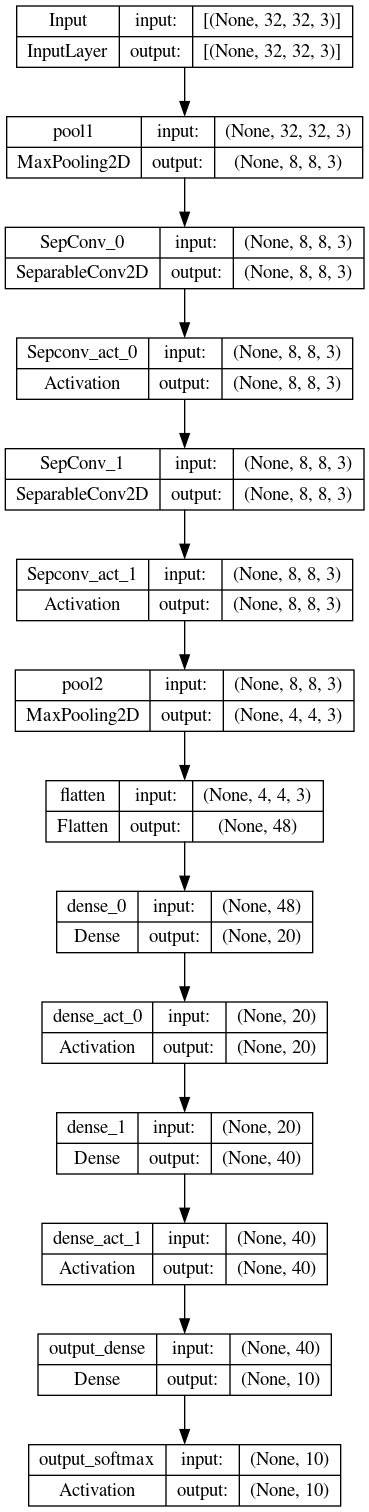

In [ ]:
import keras
keras.utils.plot_model(model, to_file="model.png",show_shapes=True, show_layer_activations=False)

In [ ]:
import hls4ml.utils
import hls4ml.converters

In [ ]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")

Interpreting Model
Topology:
Layer name: Input, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: pool1, layer type: MaxPooling2D, input shapes: [[None, 32, 32, 3]], output shape: [None, 8, 8, 3]
Layer name: SepConv_0, layer type: SeparableConv2D, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: Sepconv_act_0, layer type: Activation, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: SepConv_1, layer type: SeparableConv2D, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: Sepconv_act_1, layer type: Activation, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: pool2, layer type: MaxPooling2D, input shapes: [[None, 8, 8, 3]], output shape: [None, 4, 4, 3]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 4, 4, 3]], output shape: [None, 48]
Layer name: dense_0, layer type: Dense, input shapes: [[None, 48]], output shape: [No

In [ ]:
IO_TYPE = 'io_parallel'
STRATEGY = 'Latency'
BACKEND = 'Vivado'
FXD_W = 12 # Fixed-point precision, word bit width
FXD_I = 11 # Fixed-point precision, integer-part bit width

In [ ]:
#config['LayerName']['q_input_1']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
config['LayerName']['Input']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
config['Model']['Strategy'] = STRATEGY
#config['Model']['Strategy'] = 'Resource'

hls_model = hls4ml.converters.convert_from_keras_model(
    model, 
    hls_config=config, 
    output_dir='hls4ml_prj', 
    part='xcu250-figd2104-2L-e',
    backend=BACKEND,
    io_type=IO_TYPE
)

hls_model.compile()

Interpreting Model
Topology:
Layer name: Input, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: pool1, layer type: MaxPooling2D, input shapes: [[None, 32, 32, 3]], output shape: [None, 8, 8, 3]
Layer name: SepConv_0, layer type: SeparableConv2D, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: Sepconv_act_0, layer type: Activation, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: SepConv_1, layer type: SeparableConv2D, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: Sepconv_act_1, layer type: Activation, input shapes: [[None, 8, 8, 3]], output shape: [None, 8, 8, 3]
Layer name: pool2, layer type: MaxPooling2D, input shapes: [[None, 8, 8, 3]], output shape: [None, 4, 4, 3]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 4, 4, 3]], output shape: [None, 48]
Layer name: dense_0, layer type: Dense, input shapes: [[None, 48]], output shape: [No

KeyboardInterrupt: 

In [ ]:
hls_model.build(csim=False) #must make the input of Separable 10,10,3


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/software/xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/software/xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'russelld' on host 'mulder.t2.ucsd.edu' (Linux_x86_64 version 4.18.0-425.3.1.el8.x86_64) on Mon Jan 22 14:52:11 PST 2024
INFO: [HLS 200-10] In directory '/home/users/russelld/sConv2D_hls4ml/SepConv2D_hls4ml/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/users/russelld/sConv2D_hls4ml/SepConv2D_hls4ml/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test be

{}

## Trying Trace

In [ ]:
#config['LayerName']['Input']['Trace']=True

In [ ]:
weigth = hls_model.trace(x)

Recompiling myproject with tracing
Writing HLS project
Done


In [ ]:
x = np.random.rand(10, 3, 32, 32)

(array([[0.        , 0.        , 0.79980469, 0.        , 0.        ,
         0.        , 0.        , 0.20214844, 0.        , 0.        ],
        [0.57128906, 0.11230469, 0.01269531, 0.03320312, 0.06347656,
         0.03320312, 0.11914062, 0.00878906, 0.12695312, 0.04394531],
        [0.57128906, 0.11230469, 0.01269531, 0.03320312, 0.06347656,
         0.03320312, 0.11914062, 0.00878906, 0.12695312, 0.04394531],
        [0.57128906, 0.11230469, 0.01269531, 0.03320312, 0.06347656,
         0.03320312, 0.11914062, 0.00878906, 0.12695312, 0.04394531],
        [0.57128906, 0.11230469, 0.01269531, 0.03320312, 0.06347656,
         0.03320312, 0.11914062, 0.00878906, 0.12695312, 0.04394531],
        [0.57128906, 0.11230469, 0.01269531, 0.03320312, 0.06347656,
         0.03320312, 0.11914062, 0.00878906, 0.12695312, 0.04394531],
        [0.57128906, 0.11230469, 0.01269531, 0.03320312, 0.06347656,
         0.03320312, 0.11914062, 0.00878906, 0.12695312, 0.04394531],
        [0.57128906, 0.1123